### Visualization of the current learned Model

The model achieves a move prediction of 59% on the validation set

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [5]:
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
import matplotlib.pyplot as plt
import math
import sys
sys.path.insert(0,'../../../../')
import DeepCrazyhouse.src.runtime.color_logger
from DeepCrazyhouse.src.domain.util import *
from DeepCrazyhouse.src.domain.crazyhouse.input_representation import planes_to_board
from DeepCrazyhouse.src.tools.visualization.plane_representation import get_plane_vis
from DeepCrazyhouse.src.domain.crazyhouse.output_representation import *
from DeepCrazyhouse.src.preprocessing.dataset_loader import load_pgn_dataset
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# Save the model as png file
from keras.utils.vis_utils import plot_model
import mxnet as mx
from mxnet import gluon
from DeepCrazyhouse.configs.main_config import main_config
from glob import glob
import re
import logging
%matplotlib inline

Using MXNet backend
/home/queensgambit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
#plt.style.use("seaborn-whitegrid")
plt.style.use("seaborn-white")
logging.getLogger().setLevel(logging.INFO)

In [7]:
main_config

{'pgn_train_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/train/',
 'pgn_val_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/val/',
 'pgn_test_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/test/',
 'pgn_mate_in_one_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/mate_in_one/',
 'planes_train_dir': '/home/demo_user/datasets/lichess/Crazyhouse/planes/train/',
 'planes_val_dir': '/home/demo_user/datasets/lichess/Crazyhouse/planes/val/',
 'planes_test_dir': '/home/demo_user/datasets/lichess/Crazyhouse/planes/test/',
 'planes_mate_in_one_dir': '/home/demo_user/datasets/lichess/Crazyhouse/planes/mate_in_one/',
 'rec_dir': '/home/demo_user/datasets/lichess/Crazyhouse/rec/',
 'model_architecture_dir': '/home/queensgambit/Programming/Deep_Learning/CrazyAra_0.2.0/model/symbol/',
 'model_weights_dir': '/home/queensgambit/Programming/Deep_Learning/CrazyAra_0.2.0/model/params/'}

In [8]:
# dimensions of the generated pictures for each filter.
input_shape = (34, 8, 8)
layer_idx = 25
export_plots = True
data_name = 'data'
normalize = True
activation =  'leakyrelu' # 'prelu' # 

In [9]:
# set the context on CPU, you can switch to GPU if there is one available
ctx = mx.cpu()

## Load the test dataset
s_idcs_test, x_test, yv_test, yp_test, pgn_dataset_test = load_pgn_dataset(dataset_type='test', part_id=0, normalize=normalize, print_statistics=True, print_parameters=True)

Exception: There aren't enough parts available in the given directory for partid=0

In [ ]:
main_config["model_weights_dir"]

In [ ]:
symbol_file = glob(main_config["model_architecture_dir"] + '*')[0]
params_file = glob(main_config["model_weights_dir"] + '*')[0]

In [ ]:
net = gluon.nn.SymbolBlock.imports(symbol_file,
                                   ['data'], 
                                   param_file=params_file,
                                   ctx=mx.cpu())

In [ ]:
sym = mx.sym.load(symbol_file)

In [ ]:
# https://github.com/apache/incubator-mxnet/issues/6951
save_dict = mx.nd.load(params_file)
arg_params = {}
aux_params = {}
for k, v in save_dict.items():
    tp, name = k.split(':', 1)
    if tp == 'arg':
        arg_params[name] = v
    if tp == 'aux':
        aux_params[name] = v

In [ ]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

In [ ]:
filters_stem_conv0 = arg_params['stem_conv0_weight'].asnumpy().sum(axis=1)
filters_stem_conv0.shape

In [ ]:
f0_sym = all_layers['stem_leakyrelu0_fwd_output']
f0_mod = mx.mod.Module(symbol=f0_sym, context=ctx, label_names=None)
f0_mod.bind(for_training=False, data_shapes=[('data', input_shape)])
f0_mod.set_params(arg_params, aux_params)
f0_act_maps = predict(f0_mod, x_test[img_idx])

In [ ]:
plt.imshow(f0_act_maps[0], cmap='Blues_r')
plt.colorbar()

In [ ]:
first_kernel = arg_params['stem_conv0_weight'][0].asnumpy()

In [ ]:
def apply_def(filename):
    if export_plots is True:
        plt.savefig('./plots/%s.png'%filename, bbox='tight')
        plt.savefig('./plots/%s.pdf'%filename, bbox='tight')
        plt.savefig('./plots/%s.svg'%filename, bbox='tight')
    plt.show()

In [ ]:
def plot_multi_dim_array(dim_array, cmap='viridis', title='', flipud=True, ax_captions=None, top=0.95,
                         use_global_cmap=False, filename=None):
    
    # we sum up all value in order to represent all channel values
    #dim_array = arg_params[layer_name].asnumpy().sum(axis=1)

    nb_filters = dim_array.shape[0]
    
    # define the cell width and height based on the total number of filters
    grid_width = math.ceil(math.sqrt(nb_filters))
    # we choose a square layout
    grid_hight = grid_width
    
    fig = plt.figure(figsize=(16,16))
    #plt.title(title)
    #plt.title("Filters - Layer %s[%d]" % (layer_name, nb_filters))
    
    subplot_num = int(np.ceil(np.sqrt(nb_filters)))
    
    w_min = dim_array.min()
    w_max = dim_array.max()
        
    if ax_captions is not None:
        assert len(ax_captions) == len(dim_array)
            
    axes = []
    for i in range(nb_filters):
        ax = fig.add_subplot(subplot_num, subplot_num, i+1)
        # Only plot the valid filter-weights.
        
        axes.append(ax)
        
        if i<nb_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = dim_array[i, :, :]

        img = img.squeeze()
        if flipud is True:
            img = np.flipud(img)
            
        if use_global_cmap is True:
            # use a global cmap range for all images
            im = ax.imshow(img, cmap=cmap, interpolation='nearest', vmin=w_min, vmax=w_max)
        else:
            # calculate the cmap individually for each image
            ax.imshow(img, cmap=cmap, interpolation='nearest')

        if ax_captions is not None:
            ax.set_title(ax_captions[i])
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

    # the title must be shifted when using tight layout
    fig.subplots_adjust(top=top)        
    fig.suptitle(title, fontsize=16)
    
    if use_global_cmap is True:
        fig.colorbar(im, ax=axes)
        
    if filename is not None:
        apply_def(filename)

In [ ]:
board
board.pockets

In [ ]:
ax_captions = [
    'white pawns', 'white knights', 'white bishops', 'white rooks', 'white queens', 'white kings',
    'black pawns', 'black knights', 'black bishops', 'black rooks', 'black queens', 'black kings',
    'repetition 1', 'repetition 2',
    'white pocket pawns', 'white pocket knights', 'white pocket bishops', 'white pocket rooks', 'white pocket queens',
    'black pocket pawns', 'black pocket knights', 'black pocket bishops', 'black pocket rooks', 'black pocket queens',
    'white promoted pawns', 'black promoted pawns',
    'en-passant square',
    'current turn colour',
    'total move count',
    'white castling kings-side', 'white castling queen-side',
    'black castling kings-side', 'black castling queen-side',
    'no-progress count'
]

In [ ]:
board.fen()

In [ ]:
title = 'Input representation channels: %s\nBoard fen: %s' % (x_test[img_idx].shape, board.fen())
plot_multi_dim_array(x_test[img_idx], ax_captions=ax_captions, cmap='gray_r', title=title, top=0.9,
                     use_global_cmap=True, filename='input_channels')

In [ ]:
title = 'Activation maps after first conv-layer: ' + str(f0_act_maps.shape)
plot_multi_dim_array(f0_act_maps, cmap='Blues_r', title=title, filename='first_act_maps')

In [ ]:
plot_multi_dim_array(first_kernel, use_global_cmap=True,
                     title='First kernel filter of first conv-layer: ' + str(first_kernel.shape),
                     filename='first_kernel')

In [ ]:
plt.imshow(first_kernel[0], cmap='viridis', interpolation='nearest')
plt.colorbar()

In [ ]:
export_plots = False

In [ ]:
def show_filters(layer_name):
    
    # we sum up all value in order to represent all channel values
    filter_values = arg_params[layer_name].asnumpy().sum(axis=1)

    nb_filters = filter_values.shape[0]
    
    print(filter_values.shape)
        
    # define the cell width and height based on the total number of filters
    grid_width = math.ceil(math.sqrt(nb_filters))
    # we choose a square layout
    grid_hight = grid_width
    
    fig = plt.figure(figsize=(16,16))
    plt.title("Filters - Layer %s[%d]" % (layer_name, nb_filters))

    subplot_num = int(np.ceil(np.sqrt(nb_filters)))
    for i in range(nb_filters):
        ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    #    # Only plot the valid filter-weights.
        if i<nb_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = filter_values[i, :, :]

        ax.imshow(img.squeeze(), cmap='viridis', interpolation='nearest') #, cmap='gray_r') vmin=w_min, vmax=w_max,   
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

    strExport = 'filters_' + layer_name
    if export_plots is True:
        plt.savefig(strExport + '.png', bbox_inches='tight')
        plt.savefig(strExport + '.pdf', bbox_inches='tight')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
layer_name = 'stem_conv0_weight'
filter_values = arg_params[layer_name].asnumpy().sum(axis=1)
title = 'Kernel filter of first conv-layer - summed across axis=1 : ' + str(filter_values.shape)
plot_multi_dim_array(filter_values, cmap='viridis', filename='kernels_first_conv_layer', title=title, flipud=False)

In [ ]:
ctx = mx.cpu()

In [ ]:
input_shape = (1, x_test.shape[1], x_test.shape[2], x_test.shape[3])

In [ ]:
f_final_sym = all_layers['unitX11__plus0_output']
f_final_mod = mx.mod.Module(symbol=f_final_sym, context=ctx, label_names=None)
f_final_mod.bind(for_training=False, data_shapes=[('data', input_shape)])
f_final_mod.set_params(arg_params, aux_params)

In [ ]:
f_final_act_maps = predict(feature_mod, x_test[img_idx])

In [ ]:
title = 'Activation maps after residual tower: ' + str(f_final_act_maps.shape)
plot_multi_dim_array(f_final_act_maps, cmap='Blues_r', title=title, filename='res_tower_act_maps')

In [ ]:
f_final_act_maps.shape

In [ ]:
plt.imshow(f_act_maps[30], cmap='Blues_r')
plt.colorbar()

In [ ]:
input_shape = (1,34,8,8)

In [ ]:
p_sym = all_layers['policy_%s0_fwd_output' % activation]
p_mod = mx.mod.Module(symbol=p_sym, context=ctx, label_names=None)
p_mod.bind(for_training=False, data_shapes=[('data', input_shape)])
p_mod.set_params(arg_params, aux_params)

In [ ]:
v_sym = all_layers['value_%s0_fwd_output' % activation]
v_mod = mx.mod.Module(symbol=v_sym, context=ctx, label_names=None)
v_mod.bind(for_training=False, data_shapes=[('data', input_shape)])
v_mod.set_params(arg_params, aux_params)

In [ ]:
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

In [ ]:
def predict(mod, img_np_single):
    mod.forward(Batch(mx.nd.array([np.expand_dims(img_np_single, axis=0)])))
    act_maps = mod.get_outputs()[0]
    
    return act_maps[0].asnumpy()

#symbol_file = '/media/queensgambit/TOSHIBA/etc/Deep_ML/project/symbol/' + 'mxnet_model-symbol.json'
#sym_init = mx.symbol.load(symbol_file)
net = gluon.nn.SymbolBlock(outputs=sym, inputs=mx.sym.var(data_name))
# Set the params
net_params = net.collect_params()
for param in arg_params:
    if param in net_params:
        # print(param)
        net_params[param]._load_init(arg_params[param], ctx=ctx)
for param in aux_params:
    if param in net_params:
        # print(param)
        net_params[param]._load_init(aux_params[param], ctx=ctx)

In [ ]:
import chess.svg
from IPython.display import SVG, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [16]:
cmap = plt.get_cmap('coolwarm_r')

In [17]:
def show_piece_legend():
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    handles = []
    for player in ['white', 'black']:
        for piece in PIECES_VALUE:
            print(cmap(PIECES_VALUE[piece]))
            if player == 'white':
                handles.append(mpatches.Patch(color=cmap((PIECES_VALUE[piece]+7.5)/15), label=piece))
            else:
                handles.append(mpatches.Patch(color=cmap((7.5-(PIECES_VALUE[piece]))/15), label=piece.lower()))

        plt.legend(handles=handles, bbox_to_anchor=(1.25, 1.00))

In [18]:
for i in range(11):
    plt.imshow(get_plane_vis(x_test[i]), cmap='coolwarm_r')
    plt.xticks(np.arange(8), ('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'))
    plt.yticks(np.arange(8), ('8', '7', '6', '5', '4', '3', '2', '1'))
    show_piece_legend()
    plt.show()    
    board = planes_to_board(x_test[i], normalized_input=normalize)
    if board.turn == chess.BLACK:
        board = board.mirror()
    SVG(data=chess.svg.board(board=board, size=250))

NameError: name 'x_test' is not defined

In [ ]:
#img_idx = 10
img_idx = 42
#img_idx = 60
opts = 10

In [ ]:
board = planes_to_board(x_test[img_idx], normalized_input=normalize)
board

In [ ]:
img_single = mx.nd.array([x_test[img_idx]])
val, policy = net(img_single)
candidate_moves, probs = policy_to_moves(board, policy.asnumpy().flatten())
candidate_moves[:opts]

In [ ]:
val.asnumpy()[0][0]

In [ ]:
p_act_maps = predict(p_mod, x_test[img_idx])
print('Shape',p_act_maps.shape)
v_act_maps = predict(v_mod, x_test[img_idx])
print('Shape',v_act_maps.shape)

In [ ]:
title = 'Value activation maps: ' + str(v_act_maps.shape) + '\nPredicted value: %.3f' % val.asnumpy()[0][0]
plot_multi_dim_array(v_act_maps, cmap='inferno', title=title, filename='value_act_maps', use_global_cmap=True)

In [ ]:
#plt.imshow(np.flipud(v_act_maps[0]), cmap='inferno', alpha=.5)
plt.imshow(np.flipud(v_act_maps.sum(axis=0)), cmap='inferno', alpha=.5)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig('value_0.svg', transparent=True)

In [ ]:
title = 'Policy activation maps: ' + str(p_act_maps.shape)
plot_multi_dim_array(p_act_maps, cmap='Blues_r', title=title, filename='policy_act_maps', use_global_cmap=True)

In [ ]:
plt.imshow(np.flipud(p_act_maps[0]),  cmap='Blues_r', alpha=.5)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig('policy_0.svg', transparent=True)

In [ ]:
policy_to_move(policy.asnumpy(), is_white_to_move=True)
#plt.imshow(np.flipud(p_act_maps[0]), cmap='Blues_r', alpha=.5)
plt.imshow(np.flipud(p_act_maps.sum(axis=0)), cmap='Blues_r', alpha=.5)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig('policy_0.svg', transparent=True)

In [ ]:
plt.imshow(np.flipud(p_act_maps[1]),  cmap='Blues_r', alpha=.5)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig('policy_1.svg', transparent=True)

In [19]:
plt.imshow(get_plane_vis(x_test[img_idx]), cmap='coolwarm_r')
plt.xticks(np.arange(8), ('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'))
plt.yticks(np.arange(8), ('8', '7', '6', '5', '4', '3', '2', '1'))
show_piece_legend()
plt.tight_layout()
apply_def('board_pseudo_color')
plt.show()
board = planes_to_board(x_test[img_idx], normalized_input=normalize)
if board.turn == chess.BLACK:
    board = board.mirror()
svg_board = SVG(data=chess.svg.board(board=board, size=380))

NameError: name 'x_test' is not defined

### Save chess board to .svg file

In [ ]:
svg_board_string = svg_board._repr_svg_()
with open("plots/board.svg", "w") as text_file:
    text_file.write(svg_board_string)

In [ ]:
plt.imshow(get_plane_vis(x_test[0]), cmap='coolwarm_r')
plt.xticks(np.arange(8), ('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'))
plt.yticks(np.arange(8), ('8', '7', '6', '5', '4', '3', '2', '1'))
show_piece_legend()
plt.tight_layout()
apply_def('board_pseudo_color_start')
plt.show()
board = planes_to_board(x_test[0], normalized_input=normalize)
if board.turn == chess.BLACK:
    board = board.mirror()
svg_board = SVG(data=chess.svg.board(board=board, size=380))
svg_board_string = svg_board._repr_svg_()
with open("plots/board_start.svg", "w") as text_file:
    text_file.write(svg_board_string)

In [ ]:
def save_svg(svg_obj, filename):
    if export_plots is True:
        svg_board_string = svg_obj._repr_svg_()
        with open(filename + '.svg', "w") as text_file:
            text_file.write(svg_board_string)

### Rearange the svg files

In [ ]:
# https://stackoverflow.com/questions/31452451/importing-an-svg-file-a-matplotlib-figure
import svgutils.compose as sc

In [ ]:
# here starts the assembling using svgutils 
sc.Figure("13cm", "11cm", 
    sc.Panel(sc.SVG('board.svg')),
    sc.Panel(sc.SVG('policy_0.svg').scale(1.652).move(-152.5,-36))
    ).save("plots/policy_overlay_old_1.svg")
policy_overlay = SVG('plots/policy_overlay_old_1.svg')
policy_overlay

In [ ]:
# here starts the assembling using svgutils 
sc.Figure("13cm", "11cm", 
    sc.Panel(sc.SVG('board.svg')),
    sc.Panel(sc.SVG('policy_1.svg').scale(1.652).move(-152.5,-36))
    ).save("plots/policy_overlay_old_2.svg")
SVG('plots/policy_overlay_old_2.svg')

In [ ]:
a = [1, 2, 3]

In [ ]:
a[::-1]

## Matrix view

In [ ]:
for row in v_act_maps[0][::-1]:
    for entry in row:
        print("%02.2f" % entry, end="\t")
    print()

In [ ]:
entry

In [ ]:
value_overlay = sc.Figure("13cm", "11cm", 
    sc.Panel(sc.SVG('board.svg')),
    sc.Panel(sc.SVG('value_0.svg').scale(1.652).move(-152.5,-36))
    ).save("plots/value_overlay.svg")
SVG('plots/value_overlay.svg')

In [ ]:
board

In [ ]:
pgn_dataset_test.tree()

In [ ]:
metadata = np.array(pgn_dataset_test['metadata'])
site_mate = metadata[1:, 1]

In [ ]:
def clean_string(np_string, i):
    string = str(site_mate[i]).replace("b'", "")
    string = string.replace("'", "")
    string = string.replace('"', '')
    
    return string

In [ ]:
arrows = []
print(clean_string(site[0], 0))

for i in range(opts):
    pred_arrow = chess.svg.Arrow(candidate_moves[i].from_square, candidate_moves[i].to_square)
    arrows.append(pred_arrow)
svg_arrows = SVG(data=chess.svg.board(board=board, arrows=arrows, size=400))
svg_arrows
save_svg(svg_arrows, 'plots/svg_arrows')

In [ ]:
len(candidate_moves)

In [ ]:
opts = 10
plt.title('First %d candidate moves of %d legal moves' % (opts, len(candidate_moves)))
#candidate_moves, probs = policy_to_moves(board, pred[1][0])
plt.barh(range(opts)[::-1], probs[:opts])
ax = plt.gca()
ax.set_yticks(range(opts)[::-1])
ax.set_yticklabels(candidate_moves)
plt.xlabel('Move probability')
plt.ylabel('Move description')
apply_def('policy_distribution')

In [10]:
board_t = chess.variant.CrazyhouseBoard()

In [11]:
# https://lichess.org/Q9gzpyw5#58
fen = 'r1b1b3/pppkNp2/3Pp3/3pP1R1/1n1P1Q2/3p2P1/1PPN1PPn/1K1R1B1r/Qpb w - - 58 30'

# https://lichess.org/MAQwg9Su/black#51
fen = '5r2/ppp2ppk/2np3p/3Bp3/4P1P1/3P1Pq1/PPP2RQ1/R5K1/BNNNprbb b - - 51 26'

# https://lichess.org/4OWBHkTA#12
fen = 'r1bq1rk1/ppp1bppp/2np1n2/4p3/2B1P3/2NP1N2/PPP2PPP/R1BQ1RK1/ w - - 12 7'
fen =  'r1bqk1nr/ppppbppp/2n5/4p3/2B1P3/5N2/PPPP1PPP/RNBQK2R/ w KQkq - 6 4'


# https://lichess.org/TuZlUUqS#64
fen = '1r1k1b1r/pBppp1pp/2P2n2/4p3/2q1P1p1/2B5/PPPR1PPP/2K4R/Bqnnn w - - 64 33'

# https://lichess.org/Ps3XLu5D#14
fen = 'r1b1kbnr/ppp2ppp/2n1p3/6N1/4N1p1/4B3/PqP2PPP/R2QKB1R/Ppp w KQkq - 14 8'
fen = 'r1b1kbnr/ppp2ppp/2n1p3/6N1/3qN1p1/8/PPP2PPP/R1BQKB1R/Pp w KQkq - 12 7'

# https://lichess.org/Alp1XMb7#30
fen = 'r4bnr/ppQbk1pp/3pp3/1Pq1n1N1/6p1/2P5/PPP2PPP/R1B1KB1R/pn w KQ - 30 16'
fen = 'r4bnr/pp1bk1pp/4p3/1Pp1nqN1/5Bp1/2P5/PPP2PPP/R3KB1R/Qpn w KQ - 34 18'
fen = 'r4b1r/pp1bk1pp/4p3/bPp1Nq2/2P1nBp1/2P1P3/PP2KPPP/n6R/Qrn w - - 60 31'

# https://lichess.org/qfgMiARK/black#13
fen = 'rn1qk2r/ppp2ppp/4p3/3p1b2/1b1PnB2/2NBP3/PPP1NPPP/R2Q1RK1/ b kq - 13 7'
fen = 'rn3q2/ppp1kpRp/4p2B/5b1N/3Pp3/2P1P3/P1P2PPP/R2Q1RK1/Pnbbn b - - 31 16'

# https://lichess.org/OstHUMKU/black#19
fen = 'r2qkb1r/ppp2ppp/2n1p3/4Pb2/3Pp3/2P1B1N1/P1P3PP/R2QKB1R/NNp b KQkq - 19 10'
fen = 'r2qkb1r/ppp2ppp/2n1p3/4PNB1/3Pp3/2p1B3/P1P4P/R2Q1BK1/PNNrp b kq - 29 15'
fen = '3r1bNr/pppk1Ppp/4p3/4Pp2/4p3/2p1B3/P1Pp3P/1R1Q1BK1/NQnbnrp b - - 43 22'
fen = '3r1bNr/pppk1Ppp/4p3/4Pp2/4p3/2p1BQ2/P1Pp3P/1R3BK1/NNQbnrp b - - 45 23'

# https://lichess.org/AbrWTdjs#12
fen = 'r1bqk2r/ppp1bppp/2n2n2/3p4/2BNP3/2N5/PPP2PPP/R1BQK2R/Pp w KQkq - 12 7'
fen = 'r1bqk2r/p1p1bppp/2p5/3Nb2N/4P3/7p/PPP2PPP/R1BQK2R/NPPn w KQkq - 20 11'
fen = 'r1bqk1r1/p1p1bppp/8/3PP2N/8/8/PPP1pPpP/R1BQK1R1/PBNPnn w Qq - 28 15'
fen = 'r3k1r1/p1pqbppp/2n5/3PP2N/8/5n2/PPP1QPpP/R1BK2R1/PPNPbb w q - 38 20'
fen = 'r5r1/p1pkb1p1/2n1p1B1/4P3/5P2/4P3/PPPn2pP/R2K2R1/Pnqnqpppbb w - - 64 33'

# https://lichess.org/qg7zBWd4#20
fen = 'r2B1rk1/ppp2ppp/2np4/2bBp3/4P1b1/3P1N2/PPP2PPP/R2n1RK1/NQq w - - 20 11'
fen = 'r2B1rk1/ppp2ppp/2np4/2bBp3/4P3/3P1b2/PPP2PPP/3R1RK1/NNQnq w - - 22 12'
fen = 'r2B1rk1/ppp2p1p/2np3p/2bBp1n1/4P3/3P1bQ1/PPP2PPP/3R1RK1/Nnq w - - 26 14'
fen = 'r2n1r1k/ppp2p1p/3p1N1p/2bBp1n1/4P3/3P1PP1/PPP4P/3R1R1K/NBbqq w - - 34 18'

# https://lichess.org/XKo4gKDG/black#44
fen = 'rnQ5/ppp1bpb1/3n1kBb/3pNpp1/3P4/4p1P1/PPP2pPP/RN1Q1K1R/R w - - 44 23'
fen = 'r7/ppp1b3/b2nk1Bb/3p1ppP/3P4/4p1P1/PPP1KpPP/RN1Q3R/nqnr w - - 62 32'
fen = 'r7/ppp1b3/b2nk1Bb/3p1ppP/3P4/4pKP1/PPP2pPP/RN1Q3R/nqnr b - - 63 32'

In [12]:
board_t.set_fen(fen)# - - 59 30')

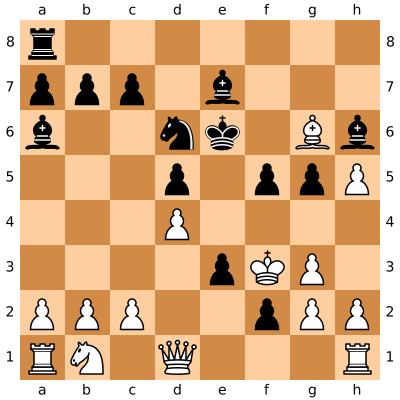

In [13]:
board_t

In [14]:
def predict_single(net, x):
    
    out = [None, None]
    pred = net(mx.nd.array(np.expand_dims(x, axis=0), ctx=ctx))
    pred[1] = pred[1].softmax()
    out[0] = pred[0].asnumpy()
    out[1] = pred[1].asnumpy()
    
    return out

In [15]:
val, policy = predict_single(net, x_blunder)

NameError: name 'net' is not defined

In [ ]:
sel_moves, probs = policy_to_moves(board_t, policy[0])

In [ ]:
probs

In [ ]:
probs[:100]

In [ ]:
sel_moves[:150]

In [ ]:
board_t.pockets

In [ ]:
# https://mxnet.incubator.apache.org/tutorials/vision/cnn_visualization.html
from __future__ import print_function

gradcam_file = "gradcam.py" 
base_url = "https://raw.githubusercontent.com/indhub/mxnet/cnnviz/example/cnn_visualization/{}?raw=true"
mx.test_utils.download(base_url.format(gradcam_file), fname=gradcam_file)
#import gradcam

In [ ]:
def show_images(pred_str, images):
    titles = [pred_str, 'Grad-CAM', 'Guided Grad-CAM', 'Saliency Map']
    num_images = len(images)
    fig=plt.figure(figsize=(15,15))
    rows, cols = 1, num_images
    for i in range(num_images):
        fig.add_subplot(rows, cols, i+1)
        plt.xlabel(titles[i])
        plt.imshow(images[i], cmap='gray' if i==num_images-1 else None)
    plt.show()

In [ ]:
def run_inference(net, data):
    out = net(data)
    return int(out[1][0].asnumpy().argmax())

In [ ]:
net(mx.nd.array(np.expand_dims(x_test[0], axis=0)))[1][0].asnumpy().argmax()

In [ ]:
def visualize(net, x, conv_layer_name):
    #orig_img = mx.img.imread(img_path)
    #preprocessed_img = preprocess(orig_img)
    #preprocessed_img = preprocessed_img.expand_dims(axis=0)
    preprocessed_img = mx.nd.array(np.expand_dims(x, axis=0))
    val_pred = run_inference(net, preprocessed_img)
    
    #orig_img = mx.image.imresize(orig_img, image_sz[0], image_sz[1]).asnumpy()
    orig_img = get_plane_vis(x)
    vizs = visualize_grad(net, preprocessed_img, orig_img, conv_layer_name)
    return (val_pred, (orig_img, *vizs))

In [ ]:
last_conv_layer_name = list(net.params.keys())[28]
print(last_conv_layer_name)

In [ ]:
from gradcam_custom import *

In [ ]:
show_images(*visualize(net, x_test[0], last_conv_layer_name))

In [ ]:
last_conv_layer_name = net.p_act_maps[28]._name
print(last_conv_layer_name)